# Librerías

In [3]:
#Librerías Base
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [4]:
#Librerías de Métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale

In [5]:
#Librerías de Machine Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop

# Conexión al repositorio de datos

In [6]:
#Accedemos a Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calibraciones

In [7]:
#Cantidad de iteraciones en el entrenamiento
numero_de_iteraciones_al_entrenar = 10

In [8]:
#Calibración del learning rate
calibracion_lr = [0.01, 0.05, 0.1, 0.5]

#Valor óptimo
lr_calibrado = 0

In [9]:
#Calibración del tamaño de batch
calibracion_batch = [16, 32, 64, 128]

#Valor óptimo
batch_calibrado = 0

In [10]:
#Calibración de optimizador
calibracion_optimizador = [
'SGD(lr=0.5)',
'SGD(lr=0.5, momentum=0.3)',
'SGD(lr=0.5, momentum=0.3, nesterov=True)',  
'Adam(lr=0.5)',
'Adagrad(lr=0.5)',
'RMSprop(lr=0.5)'
]

#Valor óptimo
optimizador_calibrado = 0

# Funciones utilitarias

In [11]:
#Vamos a crear una función utilitaria para obtener el dataframe con los "accuracy" y "loss"
def obtener_df_loss_accuracy(array_calibracion, descripcion_calibracion, array_descripciones):
  #Fusionaremos uno tras otro para crear un único registro
  #Recordemos que al usar "axis = 1" estamos fusionandolas filas
  dfDescripcion = pd.concat(array_descripciones, axis = 1)

  #A cada "loss" y "accuracy" vamos a agregarle por encima su lr
  #Obtenemos el primer elemento del array de dataframes para obtener los títulos de las columnas
  columnas_loss_accuracy = array_descripciones[0].columns

  #Vamos a crear nuevas columnas a nuestro dataframe
  #Primero colocaremos las columnas que tendrán el nombre de cada lr usado, estos valores están en "array_lr"
  #Luego, para cada "descripcion_calibracion" vamos a colocarle las columnas "columnas_loss_accuracy"
  #Estas son columnas anidadas, las podemos crear con la función "MultiIndex" de Pandas
  #Por último, con el parámetro "names" colocamos el nombre para cada agrupación de columnas
  nuevas_columnas = pd.MultiIndex.from_product(
    [array_calibracion, columnas_loss_accuracy],
    names=[descripcion_calibracion, 'metricas']
  )

  #Colocamos las nuevas columnas a nuestro dataframe
  dfDescripcion.columns = nuevas_columnas
  dfDescripcion

  #Vamos a crear el dataframe de "loss"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (loss)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfLoss = dfDescripcion.xs('loss', level = 'metricas', axis = 1)
  
  #Vamos a crear el dataframe de "accuracy"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (accuracy)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfAccuracy = dfDescripcion.xs('accuracy', level = 'metricas', axis = 1)
  dfAccuracy

  #Devolvemos los dataframes
  return dfLoss, dfAccuracy

# Lectura de datos

In [12]:
#Leemos el dataset
df = pd.read_csv('/content/drive/MyDrive/Data/RetirosFCLNuevo.csv')
df.columns =['Afiliado','Periodo','Edad','RangoEdad','Genero','EstadoCivil','EstCiv','HayRetiro','TipoRetiro','Salario','RangoSalario','SalarioPromedioRetorno','RangoSalarioRetorno','Reduccion','%Reduccion','TuvoReduccion','FechaRetorno','FechaUltimoAporte','HayAportes','Pensionado','Difunto','MesDesempleadoAntesRetorno','MesesDesempleado','MesesTrancurridos','Desempleado','EstuvoDesempleado']
df

,Afiliado,Periodo,Edad,RangoEdad,Genero,EstadoCivil,EstCiv,HayRetiro,TipoRetiro,Salario,RangoSalario,SalarioPromedioRetorno,RangoSalarioRetorno,Reduccion,%Reduccion,TuvoReduccion,FechaRetorno,FechaUltimoAporte,HayAportes,Pensionado,Difunto,MesDesempleadoAntesRetorno,MesesDesempleado,MesesTrancurridos,Desempleado,EstuvoDesempleado
0,27,2020-05-31,85,Entre59y100,F,4,VIUDO,1,E,245133.333,1,2.431900e+06,5,-2.186767e+06,-8.920723,0,2020-06-30,2020-06-30,1,1,0,1,10,11,0,0
1,217,2021-03-31,77,Entre59y100,M,1,SOLT,1,E,0.000,1,0.000000e+00,0,0.000000e+00,0.000000,0,NaN,NaN,0,1,0,1,1,1,0,0
2,227,2020-08-31,76,Entre59y100,F,2,CASAD,1,E,0.000,1,0.000000e+00,0,0.000000e+00,0.000000,0,NaN,NaN,0,1,0,8,8,8,0,0
3,286,2021-02-28,75,Entre59y100,F,1,SOLT,1,E,0.000,1,0.000000e+00,0,0.000000e+00,0.000000,0,NaN,NaN,0,1,0,2,2,2,0,0
4,345,2020-10-31,74,Entre59y100,M,3,DIVOR,1,E,32466.667,1,0.000000e+00,0,3.246667e+04,1.000000,1,NaN,NaN,0,1,0,6,6,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440053,5763772,2020-04-30,48,Entre45y59,F,0,DESC,1,S,279733.333,1,1.589767e+05,1,1.207567e+05,0.431685,1,2020-07-31,2021-04-30,9,0,0,3,0,12,0,1
440054,5763773,2021-03-31,40,Entre31y45,F,1,SOLT,1,E,1430066.667,4,0.000000e+00,0,1.430067e+06,1.000000,1,NaN,NaN,0,0,0,1,1,1,1,1
440055,5763775,2021-04-30,52,Entre45y59,F,1,SOLT,1,E,303266.667,1,3.032667e+05,1,0.000000e+00,0.000000,0,NaN,2021-04-30,0,0,0,0,0,0,0,0
440056,5763783,2020-09-30,41,Entre31y45,F,2,CASAD,1,E,421933.333,2,0.000000e+00,0,4.219333e+05,1.000000,1,NaN,NaN,0,0,0,7,7,7,1,1


# Definición de "features"

In [13]:
df.drop(['Afiliado','EstadoCivil','FechaRetorno','FechaUltimoAporte'], axis=1, inplace=True)
df.drop(['Reduccion', '%Reduccion','MesesTrancurridos'], axis=1, inplace=True)
df

,Periodo,Edad,RangoEdad,Genero,EstCiv,HayRetiro,TipoRetiro,Salario,RangoSalario,SalarioPromedioRetorno,RangoSalarioRetorno,TuvoReduccion,HayAportes,Pensionado,Difunto,MesDesempleadoAntesRetorno,MesesDesempleado,Desempleado,EstuvoDesempleado
0,2020-05-31,85,Entre59y100,F,VIUDO,1,E,245133.333,1,2.431900e+06,5,0,1,1,0,1,10,0,0
1,2021-03-31,77,Entre59y100,M,SOLT,1,E,0.000,1,0.000000e+00,0,0,0,1,0,1,1,0,0
2,2020-08-31,76,Entre59y100,F,CASAD,1,E,0.000,1,0.000000e+00,0,0,0,1,0,8,8,0,0
3,2021-02-28,75,Entre59y100,F,SOLT,1,E,0.000,1,0.000000e+00,0,0,0,1,0,2,2,0,0
4,2020-10-31,74,Entre59y100,M,DIVOR,1,E,32466.667,1,0.000000e+00,0,1,0,1,0,6,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440053,2020-04-30,48,Entre45y59,F,DESC,1,S,279733.333,1,1.589767e+05,1,1,9,0,0,3,0,0,1
440054,2021-03-31,40,Entre31y45,F,SOLT,1,E,1430066.667,4,0.000000e+00,0,1,0,0,0,1,1,1,1
440055,2021-04-30,52,Entre45y59,F,SOLT,1,E,303266.667,1,3.032667e+05,1,0,0,0,0,0,0,0,0
440056,2020-09-30,41,Entre31y45,F,CASAD,1,E,421933.333,2,0.000000e+00,0,1,0,0,0,7,7,1,1


In [14]:
# Se descartan filas y columnas innecesarias
X = df.copy()

# Limpiamos datos de salarios y edad extraños
# Se borran 18 registros con edades > 100 se asumen como anomalias.
X = X.drop(X[X['Edad']>100].index)

# Se borra salario menor que 0
X = X.drop(X[X['Salario']<0].index)
X = X.drop(X[X['SalarioPromedioRetorno']<0].index)
X = X.reset_index(drop=True)

df = X.copy()

In [15]:
def Transforma_Renombra_Datos(df_raw):
    """ Rename column names and transformed into proper format and return dataframe """
    df_cal = df_raw.copy()
    
    df_cal.rename(columns={'EstCiv':'EstadoCivil'
                       ,'DiferenciaBrechas':'Brecha'
                       ,'MesDesempleadoAntesRetorno':'InactivoPostRetiro'
                       ,'MesesDesempleado':'InactivoPostUltAporte'
                      }
              ,inplace=True)

    # Pasa a valor de texto
    df_cal['Edad'] = df_cal.Edad.astype(int)
    df_cal['RangoSalario'] = df_cal.RangoSalario.map({0:'No',1:'<=Minimo',2:'0.32-0.85',3:'0.85-1.23',4:'1.23-2.17',5:'2.17-4.33',6:'>4.33'})
    df_cal['RangoSalarioRetorno'] = df_cal.RangoSalarioRetorno.map({0:'No',1:'<=Minimo',2:'0.32-0.85',3:'0.85-1.23',4:'1.23-2.17',5:'2.17-4.33',6:'>4.33'})
    df_cal['TuvoReduccion'] = df_cal.TuvoReduccion.map({1:'Si',0:'No'})
    df_cal['TipoRetiro'] = df_cal.TipoRetiro.map({'E':'Extinción','S':'Suspensión','R':'Reducción'})
    df_cal['Pensionado'] = df_cal.Pensionado.map({1:'Si',0:'No'})
    df_cal['Desempleado'] = df_cal.Desempleado.map({1:'Si',0:'No'})
    df_cal['Difunto'] = df_cal.Difunto.map({1:'Si',0:'No'})
    df_cal['EstuvoDesempleado'] = df_cal.EstuvoDesempleado.map({1:'Si',0:'No'})


    return df_cal 

In [16]:
df = Transforma_Renombra_Datos(df)


df.head()

,Periodo,Edad,RangoEdad,Genero,EstadoCivil,HayRetiro,TipoRetiro,Salario,RangoSalario,SalarioPromedioRetorno,RangoSalarioRetorno,TuvoReduccion,HayAportes,Pensionado,Difunto,InactivoPostRetiro,InactivoPostUltAporte,Desempleado,EstuvoDesempleado
0,2020-05-31,85,Entre59y100,F,VIUDO,1,Extinción,245133.333,<=Minimo,2431900.0,2.17-4.33,No,1,Si,No,1,10,No,No
1,2021-03-31,77,Entre59y100,M,SOLT,1,Extinción,0.000,<=Minimo,0.0,No,No,0,Si,No,1,1,No,No
2,2020-08-31,76,Entre59y100,F,CASAD,1,Extinción,0.000,<=Minimo,0.0,No,No,0,Si,No,8,8,No,No
3,2021-02-28,75,Entre59y100,F,SOLT,1,Extinción,0.000,<=Minimo,0.0,No,No,0,Si,No,2,2,No,No
4,2020-10-31,74,Entre59y100,M,DIVOR,1,Extinción,32466.667,<=Minimo,0.0,No,Si,0,Si,No,6,6,No,No


In [17]:
df['EstuvoDesempleado'] = df.EstuvoDesempleado.map({'Si':1,'No':0})
df['Desempleado'] = df.Desempleado.map({'Si':1,'No':0})

In [18]:
# Se descartan la filas de pensionados ya que para el estudio no se requieren
X = df.copy()
X = X.drop(X[X['Pensionado']=='Si'].index)
X = X.drop(X[X['Difunto']=='Si'].index)
X.drop(['Pensionado'], axis=1, inplace=True)
X.drop(['Difunto'], axis=1, inplace=True)
X = X.reset_index(drop=True)
df = X.copy()
df

,Periodo,Edad,RangoEdad,Genero,EstadoCivil,HayRetiro,TipoRetiro,Salario,RangoSalario,SalarioPromedioRetorno,RangoSalarioRetorno,TuvoReduccion,HayAportes,InactivoPostRetiro,InactivoPostUltAporte,Desempleado,EstuvoDesempleado
0,2020-08-31,68,Entre59y100,F,CASAD,1,Extinción,0.000000e+00,<=Minimo,0.000000e+00,No,No,0,8,8,1,1
1,2020-11-30,66,Entre59y100,F,SOLT,1,Extinción,0.000000e+00,<=Minimo,0.000000e+00,No,No,0,5,5,1,1
2,2020-06-30,65,Entre59y100,F,VIUDO,1,Extinción,7.172333e+05,0.32-0.85,3.596667e+05,0.32-0.85,Si,1,8,2,1,1
3,2020-10-31,63,Entre59y100,F,CASAD,1,Extinción,3.152073e+07,>4.33,1.643182e+07,>4.33,Si,1,4,2,1,1
4,2020-04-30,62,Entre59y100,F,CASAD,1,Reducción,9.396667e+05,0.85-1.23,7.282000e+05,0.32-0.85,Si,12,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414701,2020-04-30,48,Entre45y59,F,DESC,1,Suspensión,2.797333e+05,<=Minimo,1.589767e+05,<=Minimo,Si,9,3,0,0,1
414702,2021-03-31,40,Entre31y45,F,SOLT,1,Extinción,1.430067e+06,1.23-2.17,0.000000e+00,No,Si,0,1,1,1,1
414703,2021-04-30,52,Entre45y59,F,SOLT,1,Extinción,3.032667e+05,<=Minimo,3.032667e+05,<=Minimo,No,0,0,0,0,0
414704,2020-09-30,41,Entre31y45,F,CASAD,1,Extinción,4.219333e+05,0.32-0.85,0.000000e+00,No,Si,0,7,7,1,1


In [19]:
### Columnas categoricas
df2 = df.copy()
df2 = pd.get_dummies(df2, columns = ['EstadoCivil'], prefix='EstadoCivil')
df2 = pd.get_dummies(df2, columns = ['RangoEdad'], prefix='RangoEdad')
df2 = pd.get_dummies(df2, columns = ['Genero'], prefix='Genero')
df2 = pd.get_dummies(df2, columns = ['TipoRetiro'], prefix='TipoRetiro')
df2 = pd.get_dummies(df2, columns = ['RangoSalario'], prefix='RangoSalario')
df2 = pd.get_dummies(df2, columns = ['RangoSalarioRetorno'], prefix='RangoSalarioRetorno')
df2 = pd.get_dummies(df2, columns = ['HayRetiro'], prefix='HayRetiro')
df2 = pd.get_dummies(df2, columns = ['TuvoReduccion'], prefix='TuvoReduccion')
#df2 = pd.get_dummies(df, columns = ['HayAportes'], prefix='HayAportes')

df2

### Escalamiento de columnas


,Periodo,Edad,Salario,SalarioPromedioRetorno,HayAportes,InactivoPostRetiro,InactivoPostUltAporte,Desempleado,EstuvoDesempleado,EstadoCivil_CASAD,EstadoCivil_DESC,EstadoCivil_DIVOR,EstadoCivil_SOLT,EstadoCivil_UNLIB,EstadoCivil_VIUDO,RangoEdad_Entre31y45,RangoEdad_Entre45y59,RangoEdad_Entre59y100,RangoEdad_Menor31,Genero_F,Genero_M,Genero_X,TipoRetiro_Extinción,TipoRetiro_Reducción,TipoRetiro_Suspensión,RangoSalario_0.32-0.85,RangoSalario_0.85-1.23,RangoSalario_1.23-2.17,RangoSalario_2.17-4.33,RangoSalario_<=Minimo,RangoSalario_>4.33,RangoSalarioRetorno_0.32-0.85,RangoSalarioRetorno_0.85-1.23,RangoSalarioRetorno_1.23-2.17,RangoSalarioRetorno_2.17-4.33,RangoSalarioRetorno_<=Minimo,RangoSalarioRetorno_>4.33,RangoSalarioRetorno_No,HayRetiro_1,TuvoReduccion_No,TuvoReduccion_Si
0,2020-08-31,68,0.000000e+00,0.000000e+00,0,8,8,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0
1,2020-11-30,66,0.000000e+00,0.000000e+00,0,5,5,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0
2,2020-06-30,65,7.172333e+05,3.596667e+05,1,8,2,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,2020-10-31,63,3.152073e+07,1.643182e+07,1,4,2,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1
4,2020-04-30,62,9.396667e+05,7.282000e+05,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414701,2020-04-30,48,2.797333e+05,1.589767e+05,9,3,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
414702,2021-03-31,40,1.430067e+06,0.000000e+00,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1
414703,2021-04-30,52,3.032667e+05,3.032667e+05,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
414704,2020-09-30,41,4.219333e+05,0.000000e+00,0,7,7,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1


In [20]:
df2.head().T

,0,1,2,3,4
Periodo,2020-08-31,2020-11-30,2020-06-30,2020-10-31,2020-04-30
Edad,68,66,65,63,62
Salario,0,0,717233,3.15207e+07,939667
SalarioPromedioRetorno,0,0,359667,1.64318e+07,728200
HayAportes,0,0,1,1,12
InactivoPostRetiro,8,5,8,4,1
InactivoPostUltAporte,8,5,2,2,0
Desempleado,1,1,1,1,0
EstuvoDesempleado,1,1,1,1,0
EstadoCivil_CASAD,1,0,0,1,1


In [21]:
df2.columns

Index(['Periodo', 'Edad', 'Salario', 'SalarioPromedioRetorno', 'HayAportes',
       'InactivoPostRetiro', 'InactivoPostUltAporte', 'Desempleado',
       'EstuvoDesempleado', 'EstadoCivil_CASAD', 'EstadoCivil_DESC',
       'EstadoCivil_DIVOR', 'EstadoCivil_SOLT', 'EstadoCivil_UNLIB',
       'EstadoCivil_VIUDO', 'RangoEdad_Entre31y45', 'RangoEdad_Entre45y59',
       'RangoEdad_Entre59y100', 'RangoEdad_Menor31', 'Genero_F', 'Genero_M',
       'Genero_X', 'TipoRetiro_Extinción', 'TipoRetiro_Reducción',
       'TipoRetiro_Suspensión', 'RangoSalario_0.32-0.85',
       'RangoSalario_0.85-1.23', 'RangoSalario_1.23-2.17',
       'RangoSalario_2.17-4.33', 'RangoSalario_<=Minimo', 'RangoSalario_>4.33',
       'RangoSalarioRetorno_0.32-0.85', 'RangoSalarioRetorno_0.85-1.23',
       'RangoSalarioRetorno_1.23-2.17', 'RangoSalarioRetorno_2.17-4.33',
       'RangoSalarioRetorno_<=Minimo', 'RangoSalarioRetorno_>4.33',
       'RangoSalarioRetorno_No', 'HayRetiro_1', 'TuvoReduccion_No',
       'TuvoReduc

In [22]:
#Seleccionamos las columnas con las que trabajaremos
x = df2[['HayAportes','InactivoPostUltAporte','InactivoPostRetiro','Genero_F', 'Genero_M',
       'Genero_X','EstadoCivil_CASAD', 'EstadoCivil_DESC',
       'EstadoCivil_DIVOR', 'EstadoCivil_SOLT', 'EstadoCivil_UNLIB',
       'EstadoCivil_VIUDO', 'RangoEdad_Entre31y45', 'RangoEdad_Entre45y59',
       'RangoEdad_Entre59y100', 'RangoEdad_Menor31', 'TipoRetiro_Extinción', 'TipoRetiro_Reducción',
       'TipoRetiro_Suspensión', 'Edad', 'Salario', 'SalarioPromedioRetorno']].values
x

array([[0.00000000e+00, 8.00000000e+00, 8.00000000e+00, ...,
        6.80000000e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
        6.60000000e+01, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.00000000e+00, 8.00000000e+00, ...,
        6.50000000e+01, 7.17233333e+05, 3.59666666e+05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.20000000e+01, 3.03266667e+05, 3.03266667e+05],
       [0.00000000e+00, 7.00000000e+00, 7.00000000e+00, ...,
        4.10000000e+01, 4.21933333e+05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.70000000e+01, 1.60000000e+05, 0.00000000e+00]])

# Definición de "labels"

In [23]:
#Definimos los labels
y = df2['Desempleado'].values
y

array([1, 1, 1, ..., 0, 1, 1])

# División de los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)

In [24]:
#Dividimos los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [25]:
#Features de entrenamiento
x_train

array([[1.10000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        4.00000000e+01, 1.58066667e+05, 2.04230555e+05],
       [8.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.90000000e+01, 2.60933333e+05, 2.82655555e+05],
       [0.00000000e+00, 1.10000000e+01, 1.10000000e+01, ...,
        5.40000000e+01, 1.47500000e+05, 0.00000000e+00],
       ...,
       [4.00000000e+00, 3.00000000e+00, 2.00000000e+00, ...,
        2.80000000e+01, 4.50000000e+04, 9.00000000e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.70000000e+01, 8.84666670e+04, 9.47466667e+05],
       [9.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.50000000e+01, 2.58000000e+04, 1.14250000e+06]])

In [26]:
#Labels de entrenamiento
y_train

array([0, 0, 1, ..., 1, 0, 0])

In [27]:
#Features de validación
x_test

array([[3.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.20000000e+01, 2.00013333e+06, 2.00013333e+06],
       [2.00000000e+00, 4.00000000e+00, 1.00000000e+00, ...,
        2.30000000e+01, 5.00000000e+05, 5.50000000e+05],
       [0.00000000e+00, 8.00000000e+00, 8.00000000e+00, ...,
        4.00000000e+01, 2.60000000e+05, 2.60000000e+05],
       ...,
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.40000000e+01, 1.33333000e+02, 2.61844444e+05],
       [4.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.10000000e+01, 0.00000000e+00, 6.84166667e+05],
       [1.20000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        4.30000000e+01, 3.85400000e+05, 2.66123077e+05]])

In [28]:
#Labels de validación
y_test

array([0, 1, 1, ..., 0, 0, 0])

# Configuración del modelo

In [29]:
#Crearemos una función que construya la red neuronal
def definicion_red_neuronal():
  #Instaciamos un modelo de machine learning vacío con "Sequential"
  model = Sequential()

  #Creamos la red neuronal
  #En la primera neurona verificamos si le hemos enviado un inicializador
  model.add(Dense(1, input_shape=(22,), activation='sigmoid'))

  #De aquí en adelante seguimos construyendo nuestra red neuronal

  return model

# Calibracion de Learning Rate

In [30]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for lr in calibracion_lr:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=lr),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #Para evitar que el output de entrenamiento se muestre en pantalla desactivamos la variable "verbose"
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

In [39]:
array_descripciones[0]

,loss,accuracy
0,216325696.0,0.711277
1,274920736.0,0.708923
2,286369248.0,0.710620
3,215252304.0,0.710969
4,268478816.0,0.711578
5,209218816.0,0.709739
6,210891904.0,0.712407
7,211580336.0,0.710336
8,217253952.0,0.711548
9,283085568.0,0.711750


In [31]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_lr, 'lr', array_descripciones)

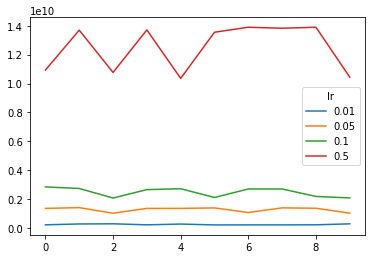

In [40]:
#Graficamos el dfLoss
dfLoss.plot()#ylim=(0,1))

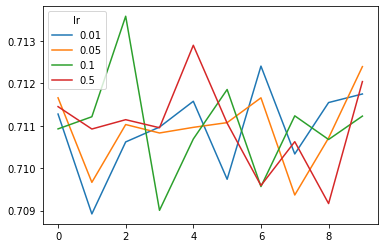

In [41]:
#Graficamos el dfLoss
dfAccuracy.plot() #ylim=(0,1))

In [42]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
lr_calibrado = 0.01

# Calibración del Batch Size

In [43]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for batch in calibracion_batch:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=lr_calibrado),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" definimos el valor
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [44]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_batch, 'batch', array_descripciones)

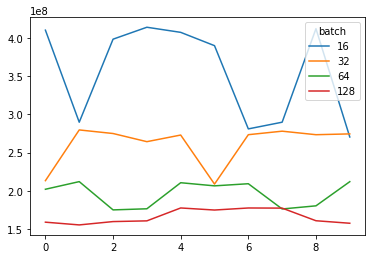

In [51]:
#Graficamos el dfLoss
dfLoss.plot()#ylim=(0,1))

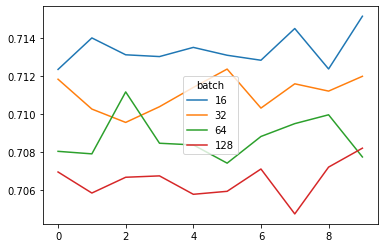

In [49]:
#Graficamos el dfLoss
dfAccuracy.plot()#ylim=(0,1))

In [52]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
batch_calibrado = 64

# Calibración del optimizador

In [53]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for optimizador in calibracion_optimizador:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()
  
  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=eval(optimizador),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" colocamos 32, ya que fue lo que encontramos en la calibración anterior
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [54]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_optimizador, 'optimizador', array_descripciones)

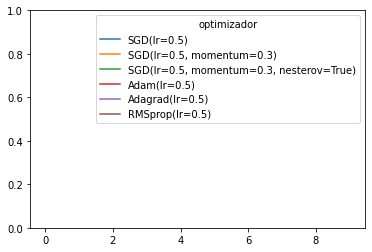

In [56]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

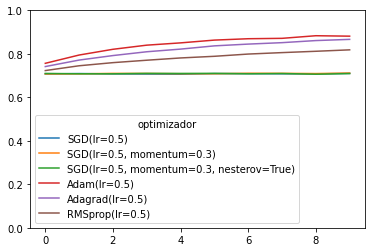

In [58]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [59]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
optimizador_calibrado = Adam(learning_rate=0.5)

# Definicion del modelo

In [71]:
#Definimos el modelo con el inicializador calibrado
model = definicion_red_neuronal()

### Aqui es donde creamos la red neuronal
# En la promera neurona verificamos si hemos enviado un inicializador

model.add(Dense(10, input_shape=(22,), activation='tanh'))
model.add(Dense(5, input_shape=(4,), activation='tanh'))
#model.add(Dense(40, input_shape(4,), activation='tanh'))
### despues de agregar 3 capas hay que recalibrar, con las capas definidas aqui.
model.add(Dense(1, input_shape=(22,), activation='sigmoid'))

# Compilación del modelo

In [72]:
#Compilamos el modelo con el optimizador calibrado
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizador_calibrado,
  metrics=['accuracy']
)

# Entrenamiento del modelo

In [73]:
#Entrenamos el modelo enviándole los features (x_train) y labels (y_train) de entrenamiento, con el batch calibrado
model.fit(x_train, y_train, epochs=numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado)

Epoch 1/10
5184/5184 [==============================] - 21s 4ms/step - loss: 0.6916 - accuracy: 0.5939
Epoch 2/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6869 - accuracy: 0.5966
Epoch 3/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6854 - accuracy: 0.5976
Epoch 4/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6875 - accuracy: 0.5949
Epoch 5/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6858 - accuracy: 0.5961
Epoch 6/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6854 - accuracy: 0.5971
Epoch 7/10
5184/5184 [==============================] - 21s 4ms/step - loss: 0.6859 - accuracy: 0.5964
Epoch 8/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6870 - accuracy: 0.5957
Epoch 9/10
5184/5184 [==============================] - 20s 4ms/step - loss: 0.6876 - accuracy: 0.5950
Epoch 10/10
5184/5184 [==============================] - 20s 4ms/step - l

# Accuracy de entrenamiento (patrones encontrados en la data)

In [74]:
#Con los features (x_train) que usamos para entrenar el modelo, realizamos las predicciones (y_train_prediccion)
y_train_prediccion = model.predict(x_train).ravel()
y_train_prediccion

array([0.17462589, 0.17462589, 0.17462589, ..., 0.17462589, 0.17462589,
       0.17462589], dtype=float32)

In [75]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_train_prediccion_binaria = y_train_prediccion > 0.5
y_train_prediccion_binaria

array([False, False, False, ..., False, False, False])

In [76]:
#Calculamos el error de entrenamiento
#INTERPRETACIÓN: El modelo encontró el 81.25% de los patrones existentes en la data
accuracy_score(y_train, y_train_prediccion_binaria)

0.6283141027959634

# Accuracy de uso (accuracy de predicción)

In [77]:
#Con los features (x_test) que no usamos para entrenar al modelo, realizamos las predicciones (y_test_prediccion)
y_test_prediccion = model.predict(x_test).ravel()
y_test_prediccion

array([0.17462589, 0.17462589, 0.17462589, ..., 0.17462589, 0.17462589,
       0.17462589], dtype=float32)

In [78]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_test_prediccion_binaria = y_test_prediccion > 0.5
y_test_prediccion_binaria

array([False, False, False, ..., False, False, False])

In [79]:
#Calculamos el error
#INTERPRETACIÓN: El modelo al ser usado en un entorno productivo, de 100 casos acertará en 80 y se equivocará en 20 casos
accuracy_score(y_test, y_test_prediccion_binaria)

0.6263895252103879

# Análisis final

In [ ]:
#El modelo tiene un alto porcentaje de reconocimiento de patrones en los datos (98.26%)
#El modelo tiene un alto porcentaje de aciertos en nuestras predicciones (98.18%)
#La diferencia entre el porcentaje de reconocimiento de patrones (98.26%) y el porcentaje de aciertos (98.18%) es pequeña (0.08%)
#Como la diferencia es pequeña, estamos frente a un modelo que representa y predice muy bien la realidad de negocio
#Es un modelo que podemos usar en un entorno real de producción